# Implementation of Traffic Sign Detection Using Capsule Network

**Univeristy of Tartu**

**Course: [Intelligent Transportation Systems](https://courses.cs.ut.ee/2020/ITS/fall)**

## Dataset

The dataset we have used here is the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

## Importing dependencies

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


print(tf.__version__)
device_name = tf.test.gpu_device_name()
print(device_name)

2.3.0
/device:GPU:0


In [ ]:
from collections import defaultdict, namedtuple
import os
import csv
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import copy

from PIL import Image


## Mounting the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Defining path

In [ ]:
data_dir = "/content/data"
result_dir = "/content/gdrive/My Drive/Classroom/ITS/my_model/model 1/result"
result_final_dir = "/content/gdrive/My Drive/Classroom/ITS/my_model/model 1/result"

weights_to_load = "/weights-20.h5"

## Fitting arguments

In [ ]:
class Args:
    def __init__(self):
        self.batch_size = 100
        self.epochs = 25
        self.lam_recon = 0.392
        self.lr = 0.001
        self.lr_decay = 0.9
        self.routings = 1


args = Args()

## Preparing dataset

In [ ]:
# Download the dataset
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -P data
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -P data
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -P data

! unzip data/GTSRB_Final_Training_Images.zip -d data
! unzip data/GTSRB_Final_Test_Images.zip -d data
! unzip data/GTSRB_Final_Test_GT.zip -d data

# Download class names
! wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv -P data

Streaming output truncated to the last 5000 lines.
  inflating: data/GTSRB/Final_Test/Images/07645.ppm  
  inflating: data/GTSRB/Final_Test/Images/07646.ppm  
  inflating: data/GTSRB/Final_Test/Images/07647.ppm  
  inflating: data/GTSRB/Final_Test/Images/07648.ppm  
  inflating: data/GTSRB/Final_Test/Images/07649.ppm  
  inflating: data/GTSRB/Final_Test/Images/07650.ppm  
  inflating: data/GTSRB/Final_Test/Images/07651.ppm  
  inflating: data/GTSRB/Final_Test/Images/07652.ppm  
  inflating: data/GTSRB/Final_Test/Images/07653.ppm  
  inflating: data/GTSRB/Final_Test/Images/07654.ppm  
  inflating: data/GTSRB/Final_Test/Images/07655.ppm  
  inflating: data/GTSRB/Final_Test/Images/07656.ppm  
  inflating: data/GTSRB/Final_Test/Images/07657.ppm  
  inflating: data/GTSRB/Final_Test/Images/07658.ppm  
  inflating: data/GTSRB/Final_Test/Images/07659.ppm  
  inflating: data/GTSRB/Final_Test/Images/07660.ppm  
  inflating: data/GTSRB/Final_Test/Images/07661.ppm  
  inflating: data/GTSRB/Final_T

In [ ]:
path = data_dir
train_path = os.path.join(path, 'GTSRB/Final_Training/Images')
test_path = os.path.join(path, 'GTSRB/Final_Test/Images')
validation_fraction = 0.2

image_size = 56

In [ ]:
Annotation = namedtuple('Annotation', ['filename', 'label'])
def read_annotations(filename):
    annotations = []
    
    with open(filename) as f:
        reader = csv.reader(f, delimiter=';')
        next(reader) # skip header

        # loop over all images in current annotations file
        for row in reader:
            filename = row[0] # filename is in the 0th column
            label = int(row[7]) # label is in the 7th column
            annotations.append(Annotation(filename, label))
            
    return annotations

In [ ]:
def load_training_annotations(source_path):
    annotations = []
    for c in range(0,43):
        filename = os.path.join(source_path, format(c, '05d'), 'GT-' + format(c, '05d') + '.csv')
        annotations.extend(read_annotations(filename))
    return annotations

In [ ]:
def load_image(annotation, source_path):
  folder_name = str(annotation.label)
  if len(folder_name) == 1:
    folder_name = "0000"+folder_name
  else:
    folder_name = "000"+folder_name
  img_path = os.path.join(source_path, folder_name)
  img_path = os.path.join(img_path, annotation.filename)
  return Image.open(img_path)

def load_test_image(annotation, test_path):
  img_path = os.path.join(test_path, annotation.filename)
  return Image.open(img_path)

In [ ]:
def split_train_validation_sets(source_path, validation_fraction=0.2):
    train_annotation = []
    val_annotation = []
    train_index = 0
    
    annotations = load_training_annotations(source_path)
    filenames = defaultdict(list)
    for annotation in annotations:
        filenames[annotation.label].append(annotation.filename)

    for label, filenames in filenames.items():
        filenames = sorted(filenames)
        
        validation_size = int(len(filenames) // 30 * validation_fraction) * 30
        train_filenames = filenames[validation_size:]
        validation_filenames = filenames[:validation_size]
        for f_name in train_filenames:
          train_annotation.append(Annotation(f_name, label))
        for f_name in validation_filenames:
          val_annotation.append(Annotation(f_name, label))

    return train_annotation, val_annotation

In [ ]:
test_annotations = read_annotations(data_dir+'/GT-final_test.csv')
train_annotations, val_annotations = split_train_validation_sets(train_path,validation_fraction)

In [ ]:
class_names = list(pd.read_csv(data_dir+"/signnames.csv")["SignName"])

In [ ]:
random.shuffle(train_annotations)
random.shuffle(test_annotations)
random.shuffle(val_annotations)

In [ ]:
x_train = np.empty((len(train_annotations),image_size,image_size,3), dtype=np.float32)
y_train = np.array([], dtype=np.float32)
for i, a in enumerate(train_annotations):
  x_train[i] = np.array(load_image(a, train_path).resize((image_size,image_size)))/255.0
  y_train = np.append(y_train,a.label)


x_valid = np.empty((len(val_annotations),image_size,image_size,3), dtype=np.float32)
y_valid = np.array([], dtype=np.float32)
for i, a in enumerate(val_annotations):
  x_valid[i] = np.array(load_image(a, train_path).resize((image_size,image_size)))/255.0
  y_valid = np.append(y_valid,a.label)


x_test = np.empty((len(test_annotations),image_size,image_size,3), dtype=np.float32)
y_test = np.array([], dtype=np.float32)
for i, a in enumerate(test_annotations):
  x_test[i] = np.array(load_test_image(a, test_path).resize((image_size,image_size)))/255.0
  y_test = np.append(y_test, a.label)

In [ ]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(31919, 56, 56, 3)
(7290, 56, 56, 3)
(12630, 56, 56, 3)


In [ ]:
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(31919,)
(7290,)
(12630,)


In [ ]:
n_train = x_train.shape[0]
n_validation = x_valid.shape[0]
n_test = x_test.shape[0]
image_shape = x_train.shape[1:]
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 31919
Number of testing examples = 12630
Image data shape = (56, 56, 3)
Number of classes = 43


In [ ]:
y_train_category = copy.deepcopy(y_train)
y_valid_category = copy.deepcopy(y_valid)
y_test_category = copy.deepcopy(y_test)

y_train = to_categorical(y_train.astype('float32'))
y_test = to_categorical(y_test.astype('float32'))
y_valid = to_categorical(y_valid.astype('float32'))

### Caps Layer

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, layers


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        #return activations.softmax(K.sqrt(K.sum(K.square(inputs), axis=-1)), axis=-1)
        return K.sqrt(K.sum(K.square(inputs), axis=-1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = tf.one_hot(indices=tf.argmax(x, 1), depth=x.shape[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * tf.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        # Transform matrix, from each input capsule to each output capsule, there's a unique weight as in Dense layer.
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule, 1]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule, 1]
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1, 1])



        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule, 1]
        # Regard the first two dimensions as `batch` dimension, then
        # matmul(W, x): [..., dim_capsule, input_dim_capsule] x [..., input_dim_capsule, 1] -> [..., dim_capsule, 1].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled), [4])


        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, 1, self.input_num_capsule].
        #b_placeholder = tf.keras.backend.placeholder(shape=(inputs.shape[0], self.num_capsule, 1, self.input_num_capsule))
        #b = tf.zeros_like(b_placeholder, tf.float32)
        #b = tf.zeros(shape=[inputs.shape[0], self.num_capsule, 1, self.input_num_capsule])
        b = tf.zeros_like(tf.expand_dims(inputs_hat[:,:,:,0],axis=2))


        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, 1, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)


            # c.shape = [batch_size, num_capsule, 1, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [..., 1, input_num_capsule] x [..., input_num_capsule, dim_capsule] -> [..., 1, dim_capsule].
            # outputs.shape=[None, num_capsule, 1, dim_capsule]
            outputs = squash(tf.matmul(c, inputs_hat))  # [None, 10, 1, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, 1, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension, then
                # matmal:[..., 1, dim_capsule] x [..., input_num_capsule, dim_capsule]^T -> [..., 1, input_num_capsule].
                # b.shape=[batch_size, num_capsule, 1, input_num_capsule]
                b += tf.matmul(outputs, inputs_hat, transpose_b=True)
        # End: Routing algorithm -----------------------------------------------------------------------#


        return tf.squeeze(outputs, [2])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """

    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    dim_temp = output.shape[2]*output.shape[3]
    outputs = layers.Reshape(target_shape=[dim_temp, dim_capsule], name='primarycap_reshape')(output)
    o = layers.Lambda(squash, name='primarycap_squash')(outputs)
    return o

### Traffic Sign Detection Capsule Network

In [ ]:
from tensorflow.keras import layers, models, optimizers, activations
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

K.set_image_data_format('channels_last')

def CapsNet(input_shape, n_class, routings, batch_size):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :param batch_size: size of batch
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape) ###, batch_size=batch_size

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=2, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    out_caps = Length(name='classifier')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16 * n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(4096, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and prediction
    train_model = models.Model([x,y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])
    return train_model, eval_model

In [ ]:
train_model, eval_model = CapsNet(input_shape=x_train.shape[1:], n_class=len(np.unique(np.argmax(y_train, 1))),
                                                   routings=args.routings,
                                                   batch_size=args.batch_size)
train_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 256)  62464       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 8, 8, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 2048, 8)      0           primarycap_conv2d[0][0]          
_______________________________________________________________________________________

In [ ]:
eval_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56, 56, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 256)  62464       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 8, 8, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 2048, 8)      0           primarycap_conv2d[0][0]          
_______________________________________________________________________________________

In [ ]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    # return tf.reduce_mean(tf.square(y_pred))
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))

    return tf.reduce_mean(tf.reduce_sum(L, 1))

In [ ]:
train_model.compile(
              optimizer=optimizers.Adam(lr=args.lr),
              loss=[margin_loss, 'mse'],
              loss_weights=[1., args.lam_recon],
              metrics={'classifier': 'accuracy'})

In [ ]:
# callbacks
log = callbacks.CSVLogger(result_dir + '/log.csv')
checkpoint = callbacks.ModelCheckpoint(result_dir + '/weights-{epoch:02d}.h5', monitor='val_classifier_accuracy',
                                        save_best_only=False, save_weights_only=True, verbose=1)
lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * (args.lr_decay ** epoch))

# Training without data augmentation:
train_model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
          validation_data=([x_test, y_test], [y_test, x_test]),
          callbacks=[log, checkpoint, lr_decay]
          )

train_model.save_weights(result_dir + '/trained_model.h5')
print('Trained model saved to \'%s/trained_model.h5\'' % result_dir)

Epoch 1/25
320/320 [==============================] - ETA: 0s - loss: 0.4266 - classifier_loss: 0.4005 - decoder_loss: 0.0664 - classifier_accuracy: 0.4908
Epoch 00001: saving model to /content/gdrive/My Drive/Classroom/ITS/my_model/model 1/result/weights-01.h5
320/320 [==============================] - 255s 797ms/step - loss: 0.4266 - classifier_loss: 0.4005 - decoder_loss: 0.0664 - classifier_accuracy: 0.4908 - val_loss: 0.1811 - val_classifier_loss: 0.1569 - val_decoder_loss: 0.0616 - val_classifier_accuracy: 0.8908
Epoch 2/25
320/320 [==============================] - ETA: 0s - loss: 0.0936 - classifier_loss: 0.0759 - decoder_loss: 0.0451 - classifier_accuracy: 0.9746
Epoch 00002: saving model to /content/gdrive/My Drive/Classroom/ITS/my_model/model 1/result/weights-02.h5
320/320 [==============================] - 282s 880ms/step - loss: 0.0936 - classifier_loss: 0.0759 - decoder_loss: 0.0451 - classifier_accuracy: 0.9746 - val_loss: 0.1081 - val_classifier_loss: 0.0897 - val_decod

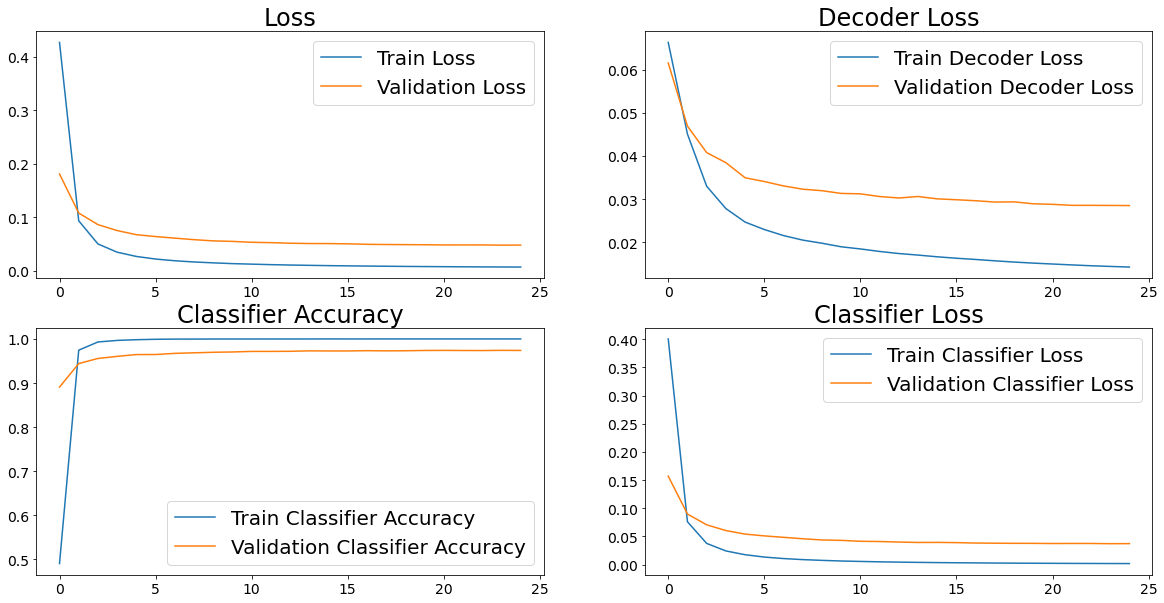

In [ ]:
def plot_train_log():
    logs = pd.read_csv(result_final_dir+"/log.csv")
    fig = plt.figure(figsize=(20,10))
    
    fig.add_subplot(221)
    plt.plot(logs.epoch, logs.loss, label='Train Loss')
    plt.plot(logs.epoch, logs.val_loss, label='Validation Loss')
    plt.title("Loss", fontsize=24)
    plt.legend(prop={'size': 20})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    fig.add_subplot(222)
    plt.plot(logs.epoch, logs.decoder_loss, label='Train Decoder Loss')
    plt.plot(logs.epoch, logs.val_decoder_loss, label='Validation Decoder Loss')
    plt.title("Decoder Loss", fontsize=24)
    plt.legend(prop={'size': 20})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    fig.add_subplot(223)
    plt.plot(logs.epoch, logs.classifier_accuracy, label='Train Classifier Accuracy')
    plt.plot(logs.epoch, logs.val_classifier_accuracy, label='Validation Classifier Accuracy')
    plt.title("Classifier Accuracy", fontsize=24)
    plt.legend(prop={'size': 20})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    fig.add_subplot(224)
    plt.plot(logs.epoch, logs.classifier_loss, label='Train Classifier Loss')
    plt.plot(logs.epoch, logs.val_classifier_loss, label='Validation Classifier Loss')
    plt.title("Classifier Loss", fontsize=24)
    plt.legend(prop={'size': 20})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plot_train_log()

In [ ]:
y_train_pred, x_train_recon = eval_model.predict(x_train, batch_size=args.batch_size)
y_valid_pred, x_valid_recon = eval_model.predict(x_valid, batch_size=args.batch_size)
y_test_pred, x_test_recon = eval_model.predict(x_test, batch_size=args.batch_size)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def print_metrics(y_true, y_pred, dataset_name):
    print('-' * 30 + dataset_name + '-' * 30)
    print("")
    y_t = list(np.argmax(y_true,axis=1))
    y_p = list(np.argmax(y_pred, axis=1))
    print(f'{dataset_name} acc:', accuracy_score(y_t, y_p))
    print(f'{dataset_name} f1:', f1_score(y_t, y_p, average='macro'))
    print("")
    print("")

print_metrics(y_train, y_train_pred, "Train")
print_metrics(y_valid, y_valid_pred, "Validation")
print_metrics(y_test, y_test_pred, "Test")

------------------------------Train------------------------------

Train acc: 1.0
Train f1: 1.0


------------------------------Validation------------------------------

Validation acc: 0.9698216735253772
Validation f1: 0.9214275820895599


------------------------------Test------------------------------

Test acc: 0.973950910530483
Test f1: 0.9587816645316041




## Load model

In [ ]:
#eval_model.load_weights(result_final_dir + weights_to_load)

In [ ]:
#y_test_pred, x_test_recon = eval_model.predict(x_test, batch_size=args.batch_size)
#print_metrics(y_test, y_test_pred, "Test")

In [ ]:
def plot_img(x_test, x_recon, y_test, y_pred, index1, index2):
    fig = plt.figure(figsize=(25,5))
    fig.add_subplot(141)
    plt.imshow(x_test[index1])
    plt.title(f"Original image ({class_names[np.argmax(y_test[index1])]})")

    fig.add_subplot(142)
    plt.imshow(x_recon[index1])
    plt.title(f"Reconstructed image ({class_names[np.argmax(y_pred[index1])]})")

    fig.add_subplot(143)
    plt.imshow(x_test[index2])
    plt.title(f"Original image ({class_names[np.argmax(y_test[index2])]})")

    fig.add_subplot(144)
    plt.imshow(x_recon[index2])
    plt.title(f"Reconstructed image ({class_names[np.argmax(y_pred[index2])]})")

    plt.show() 

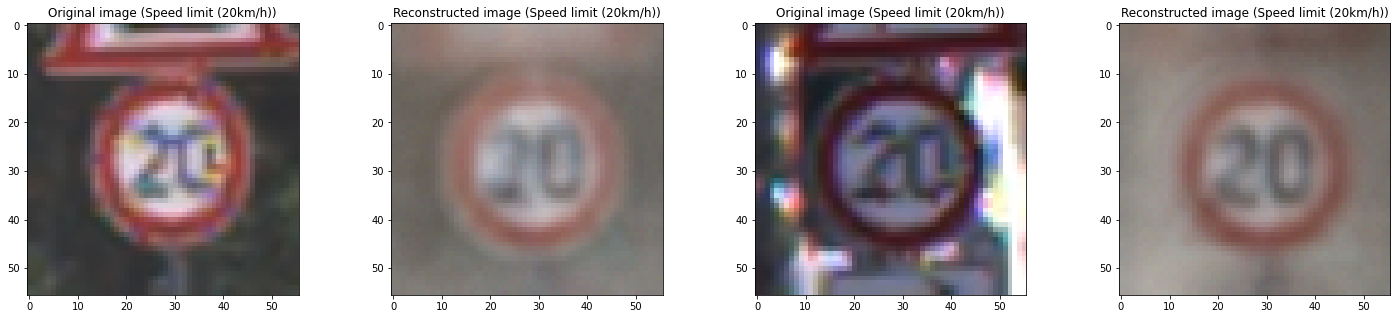

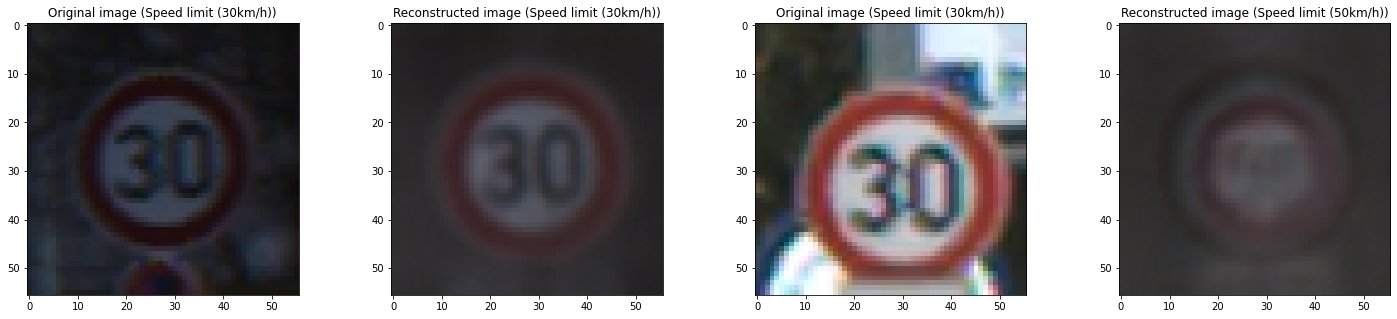

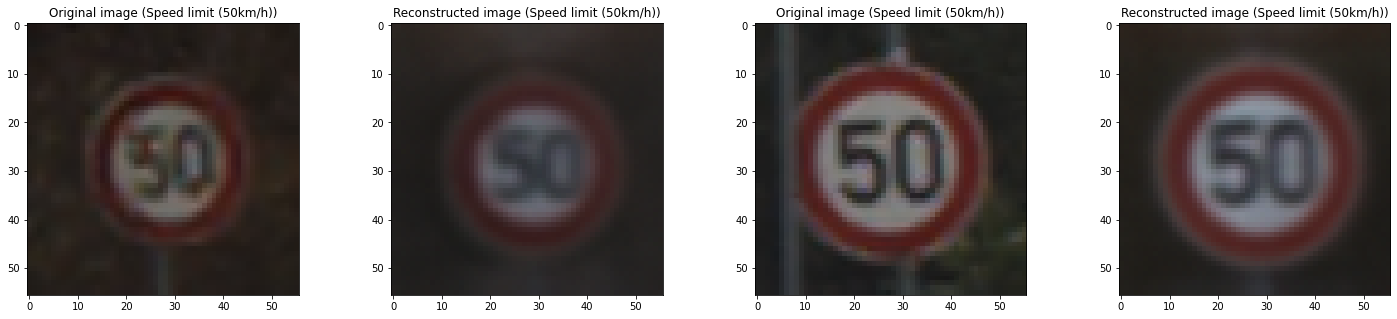

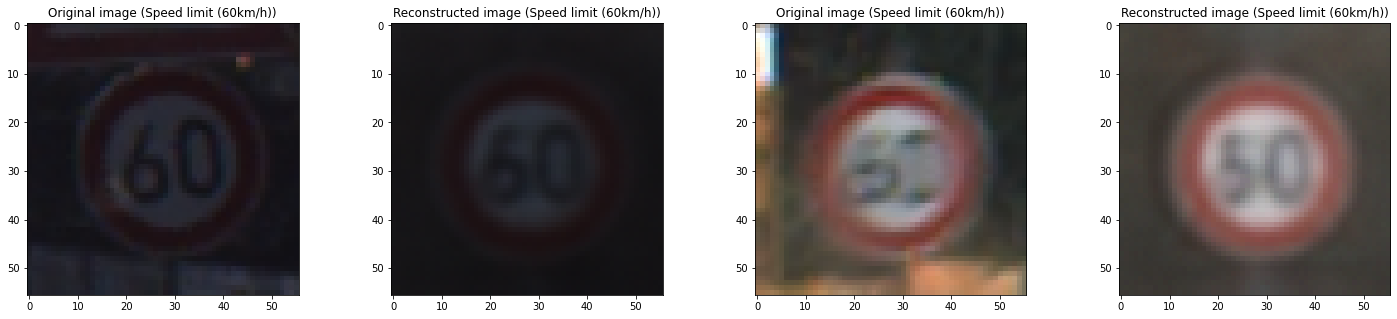

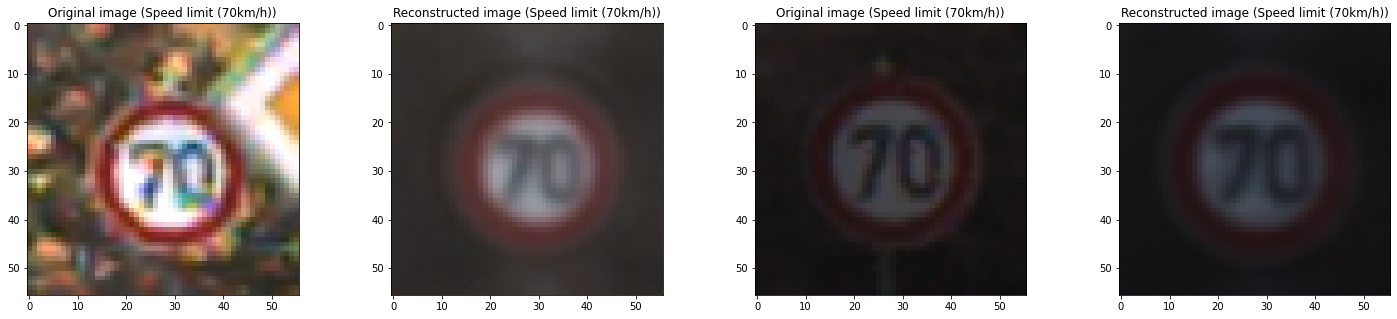

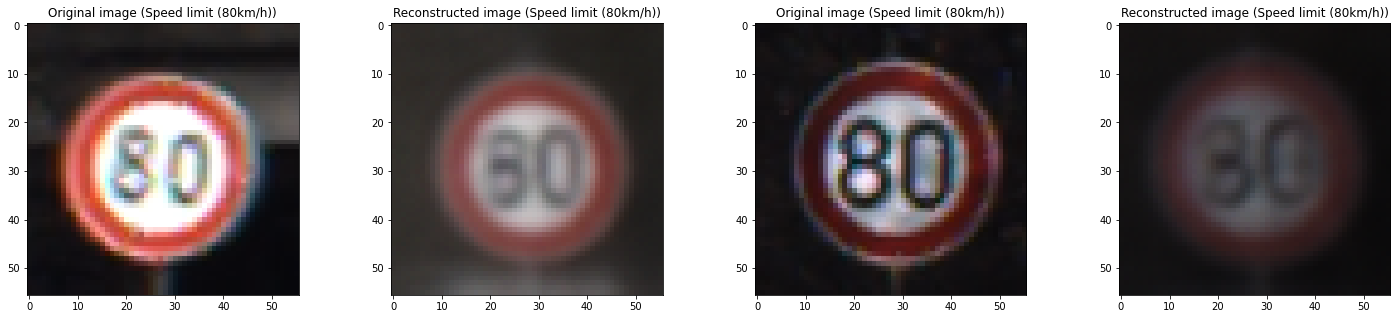

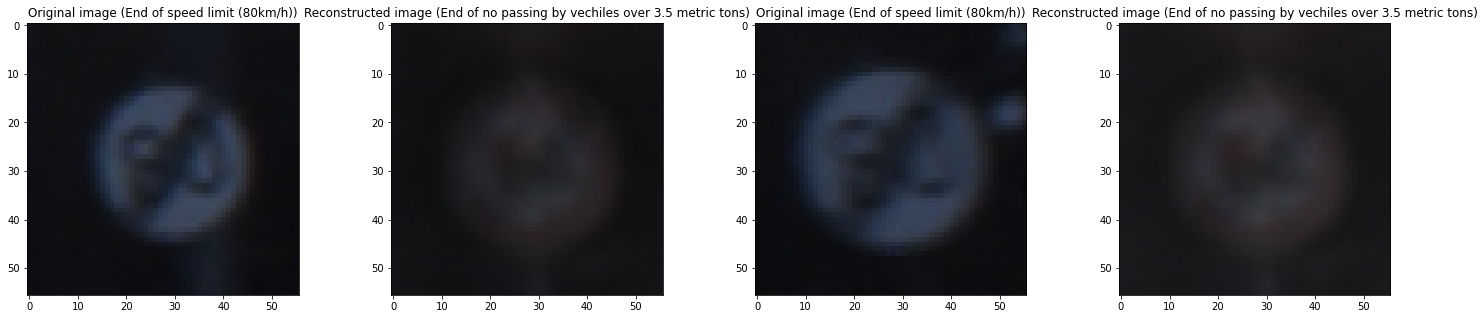

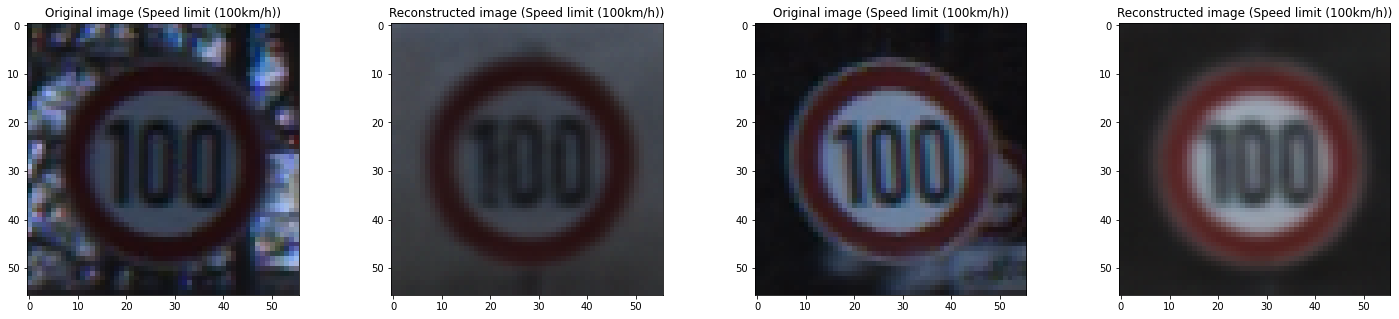

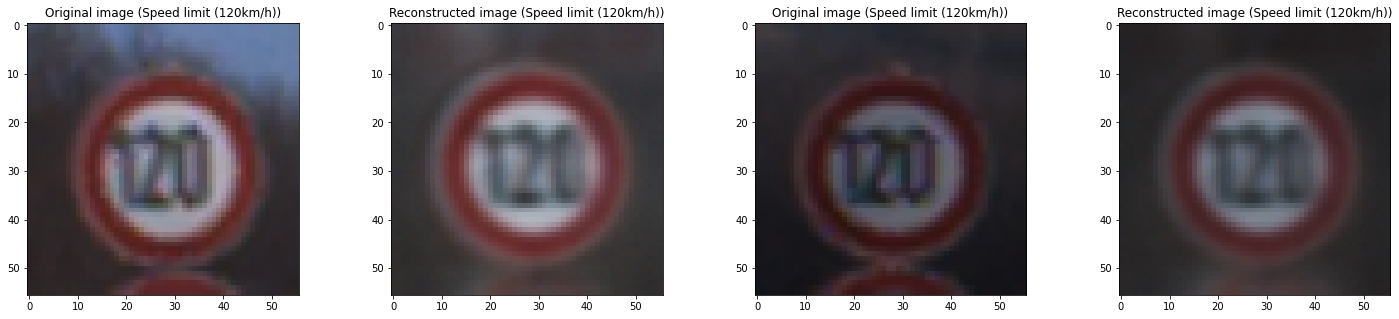

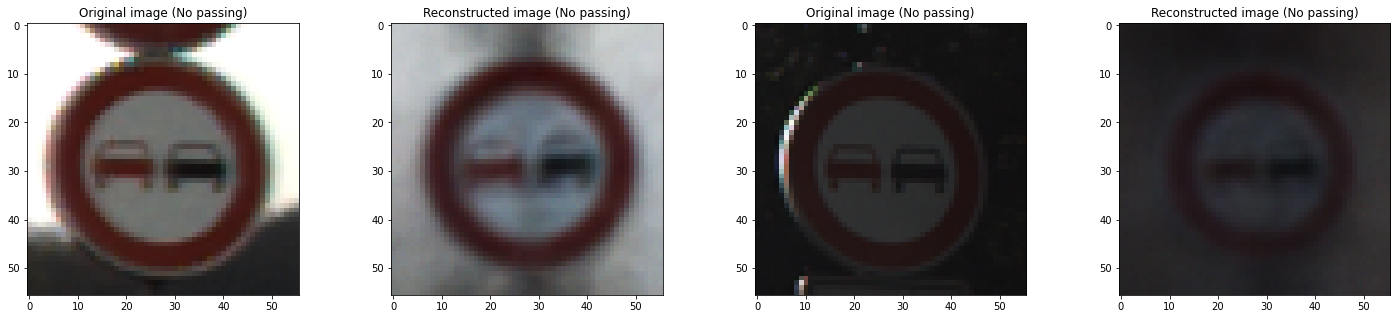

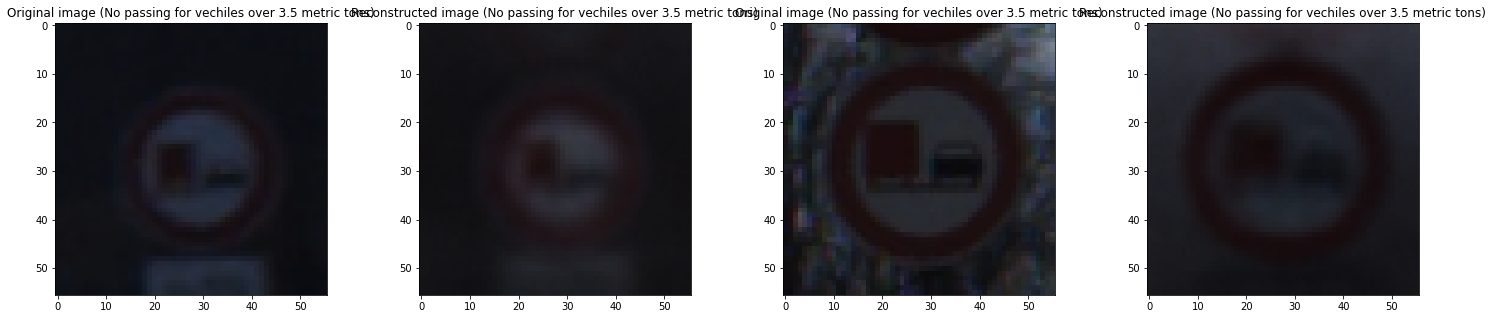

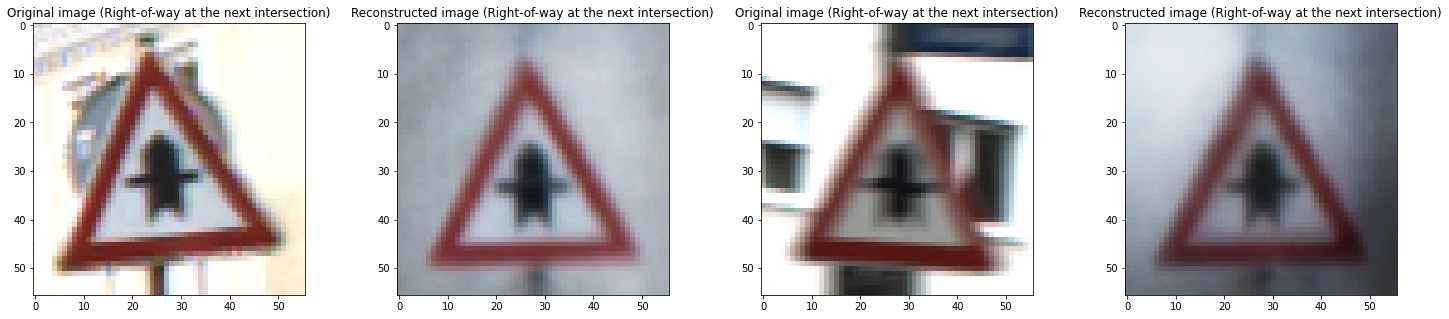

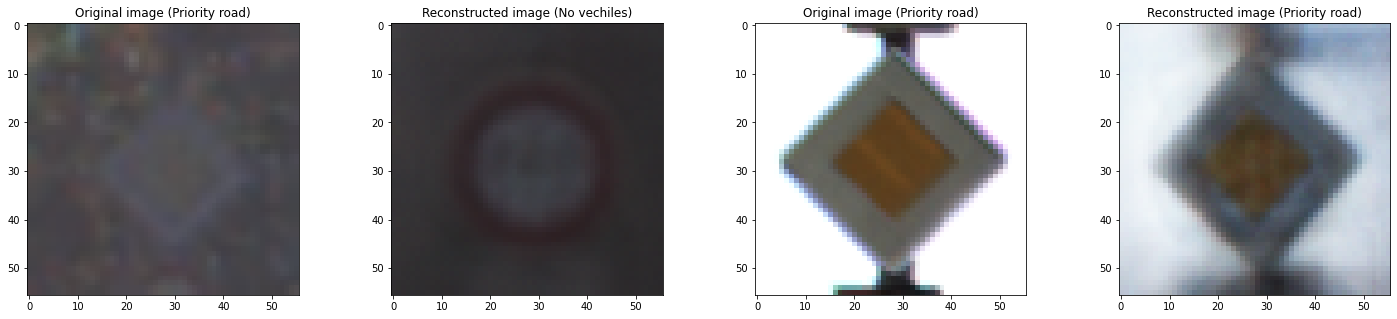

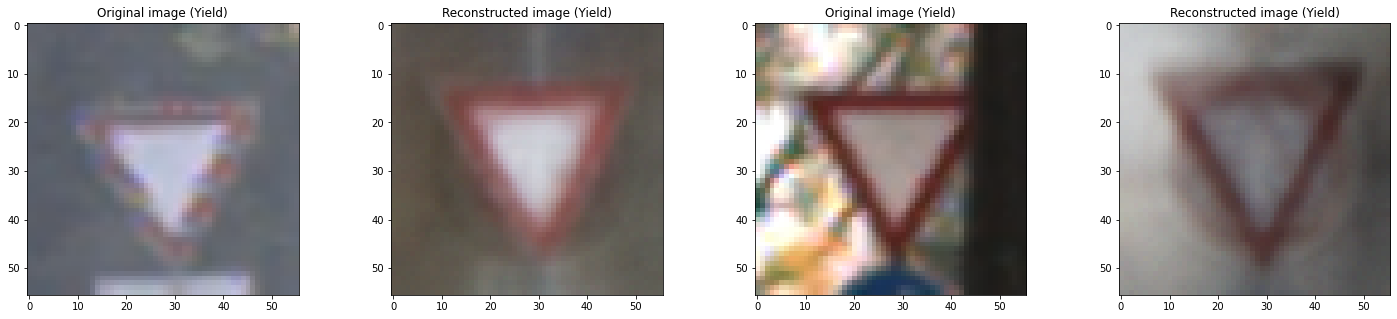

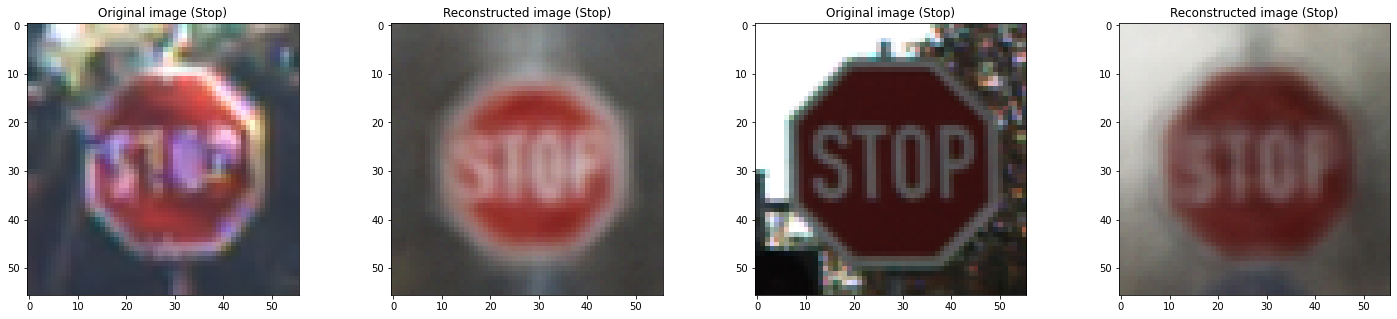

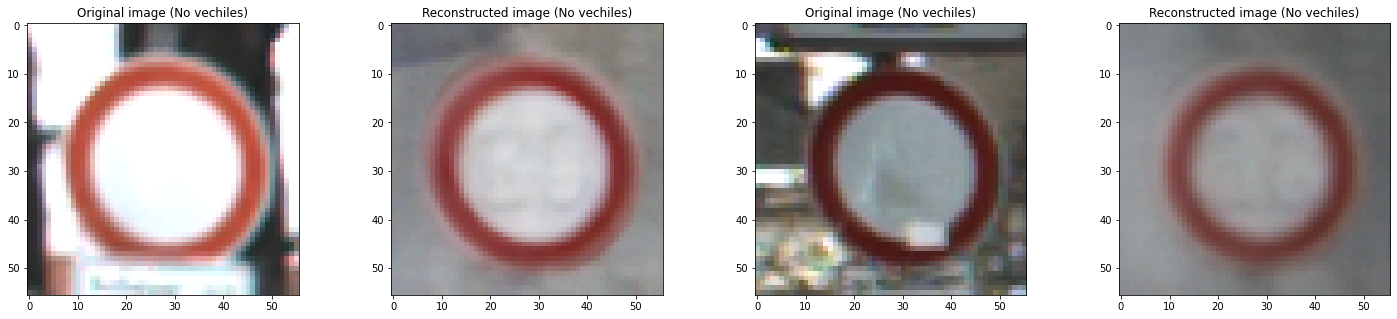

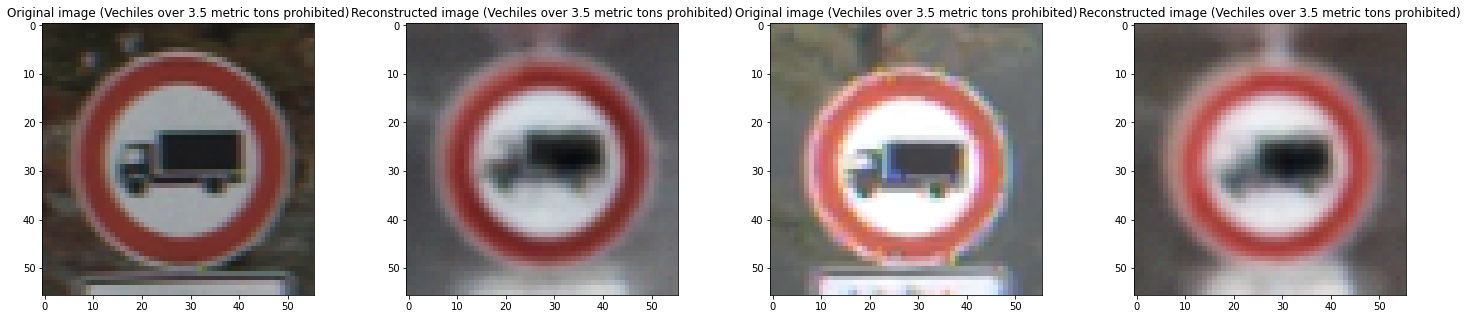

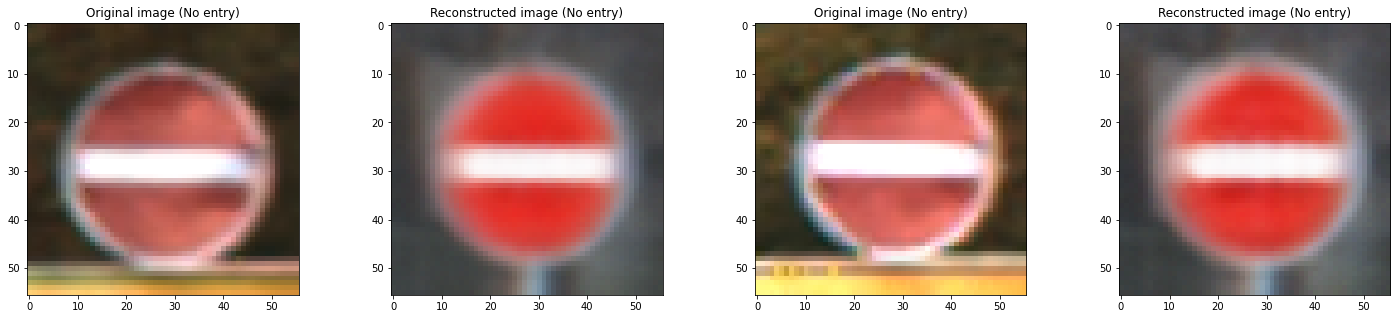

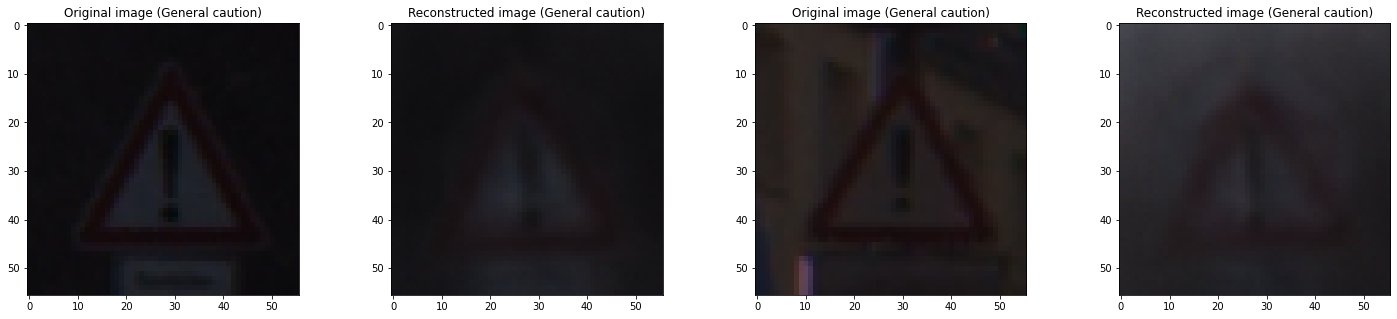

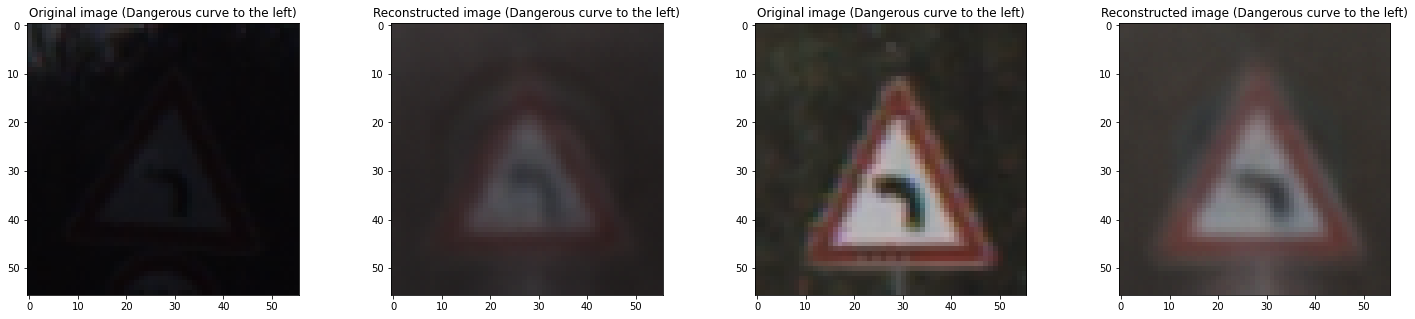

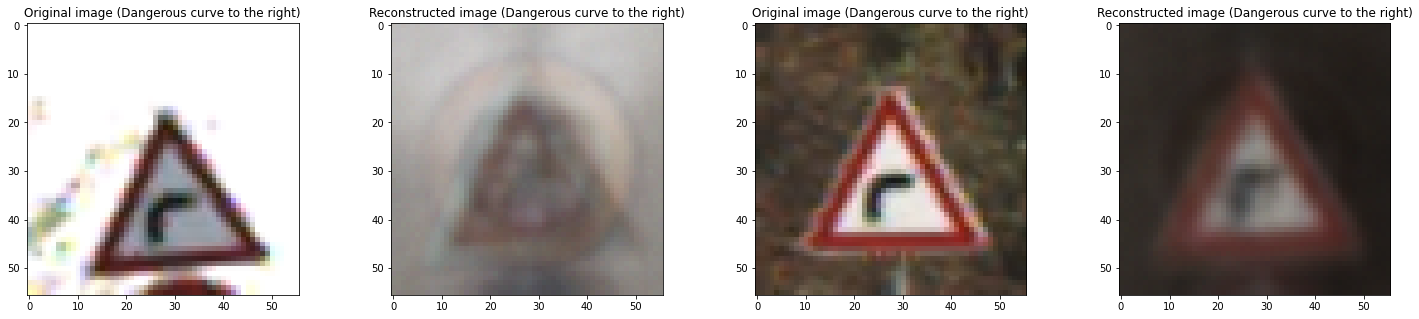

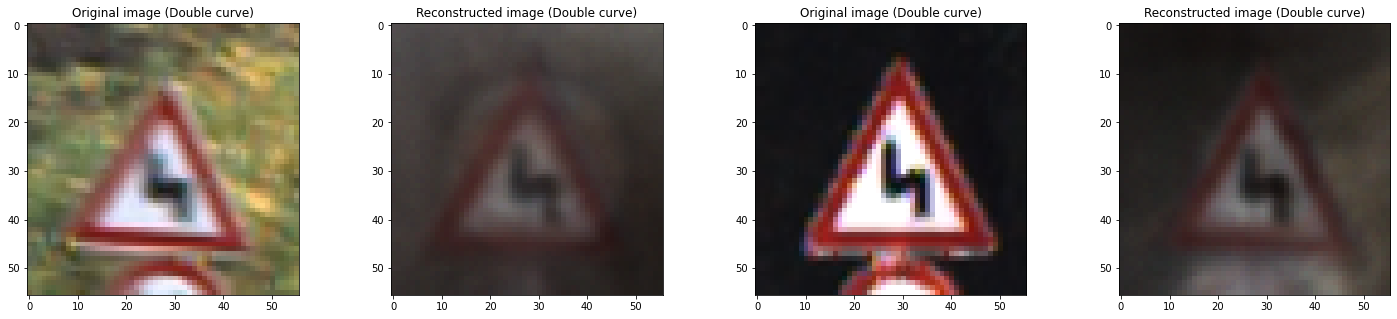

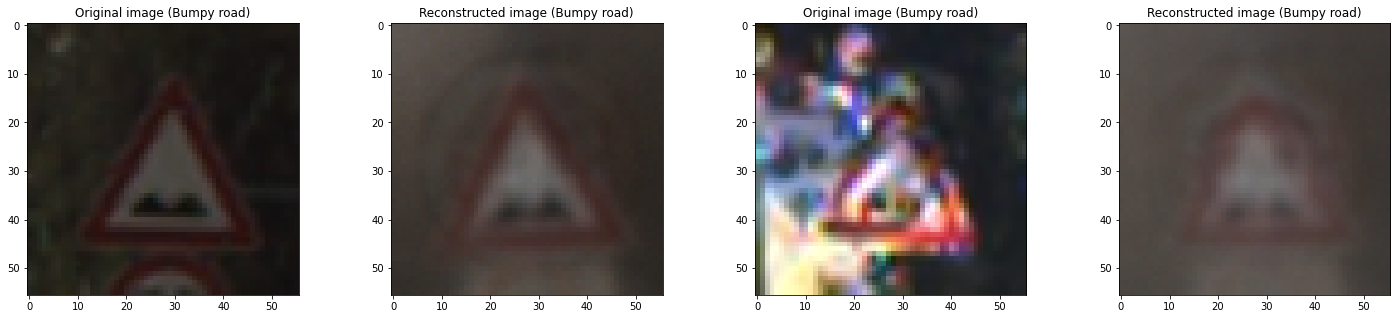

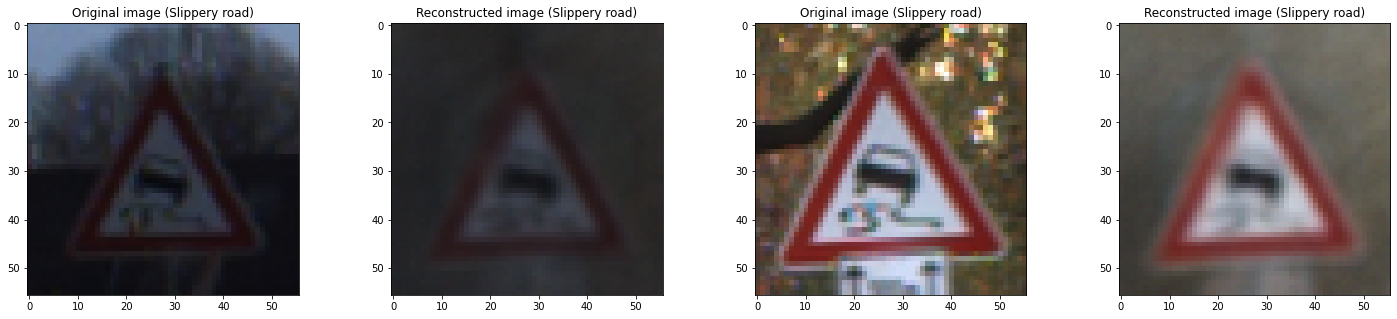

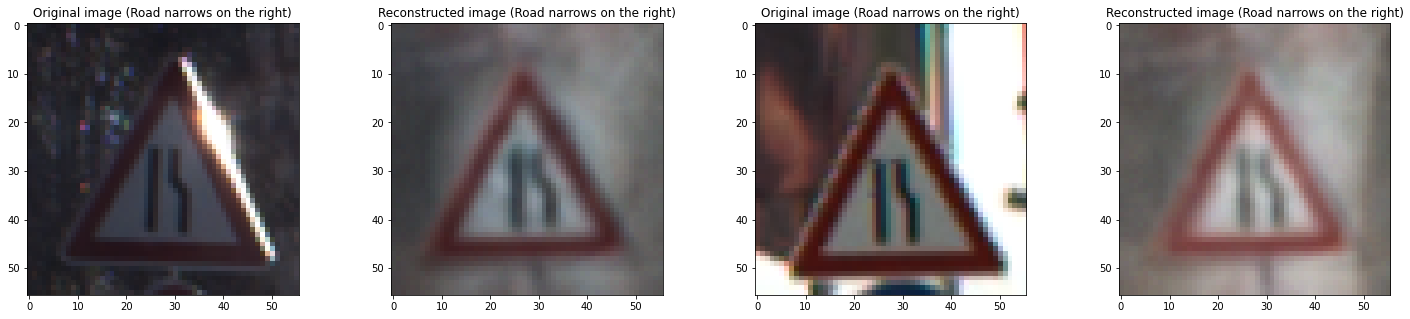

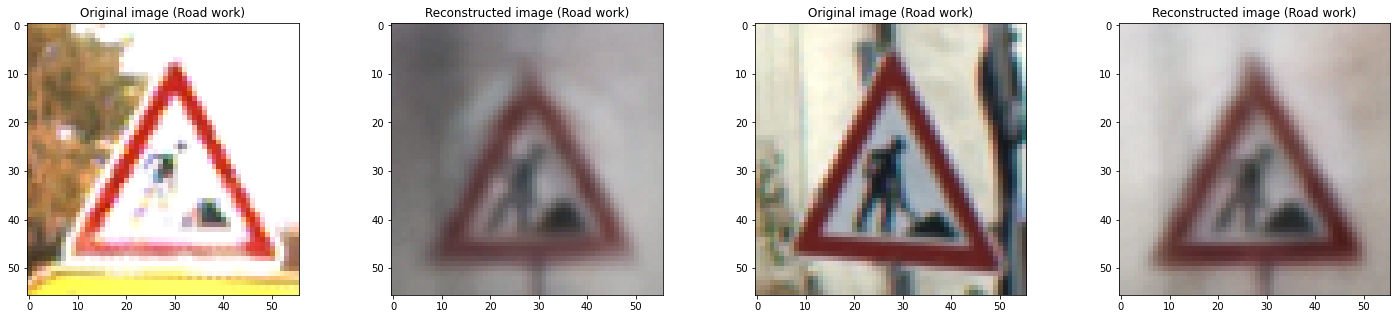

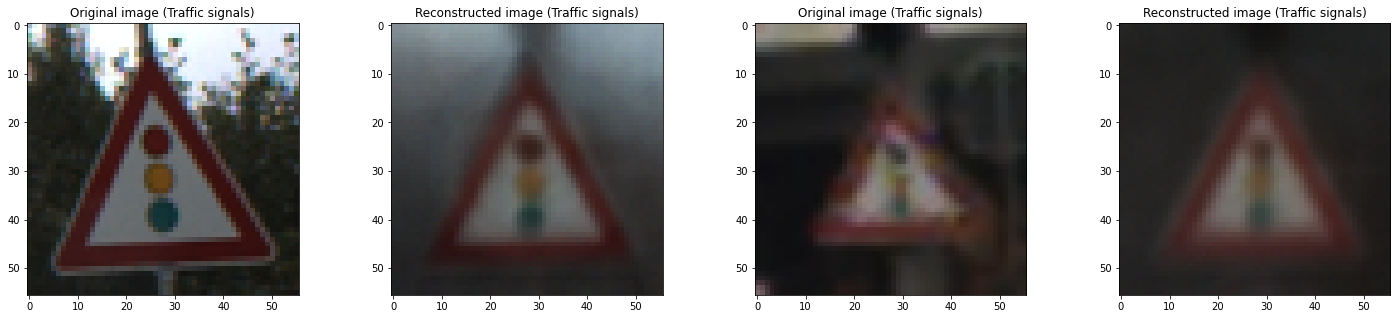

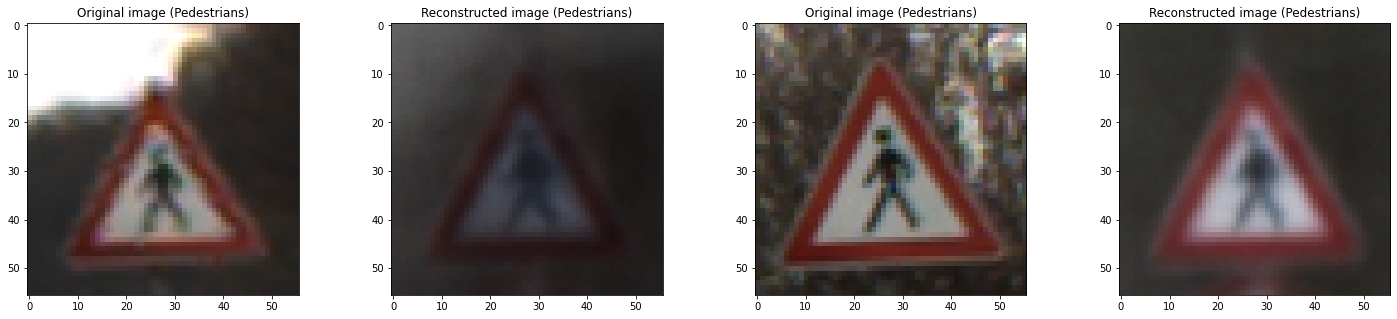

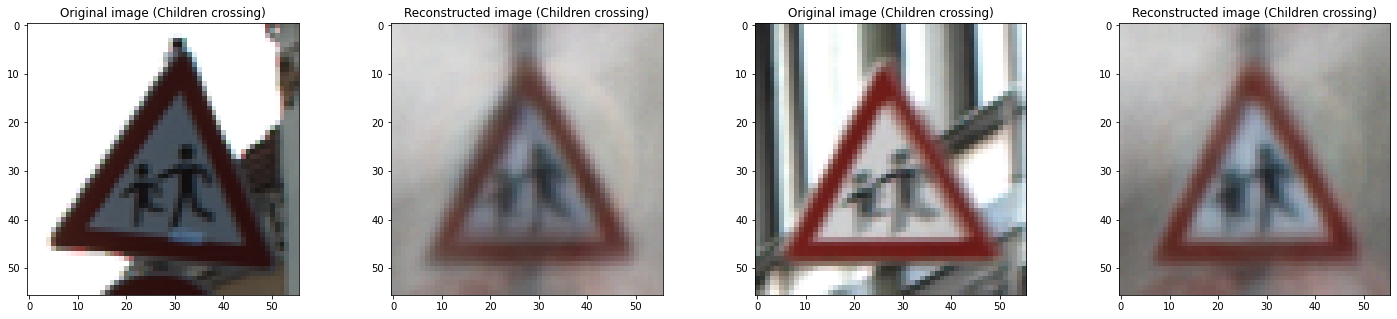

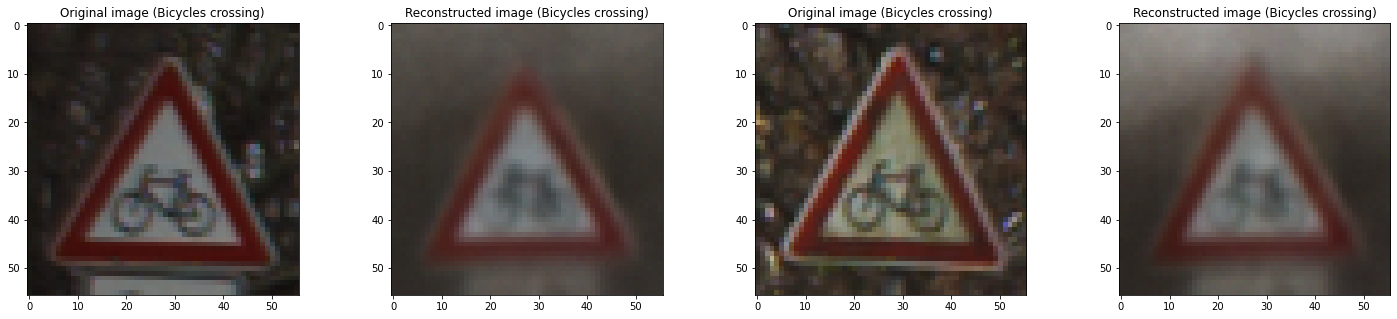

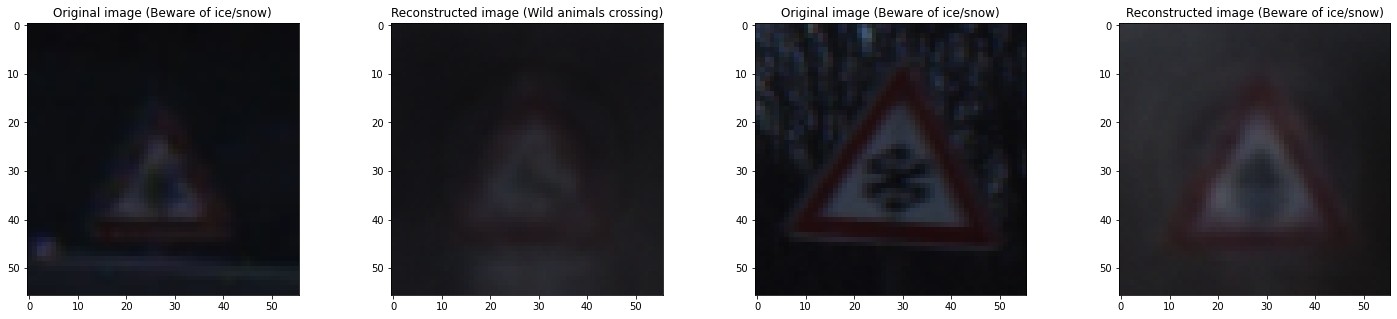

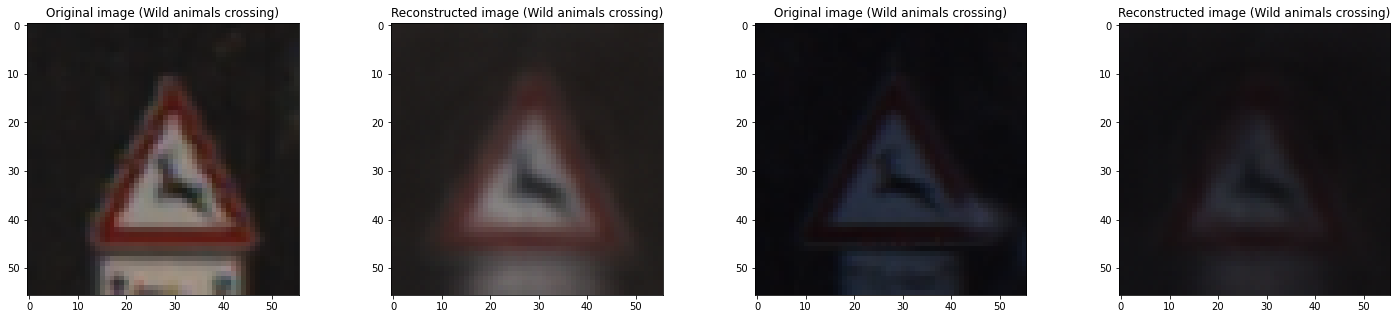

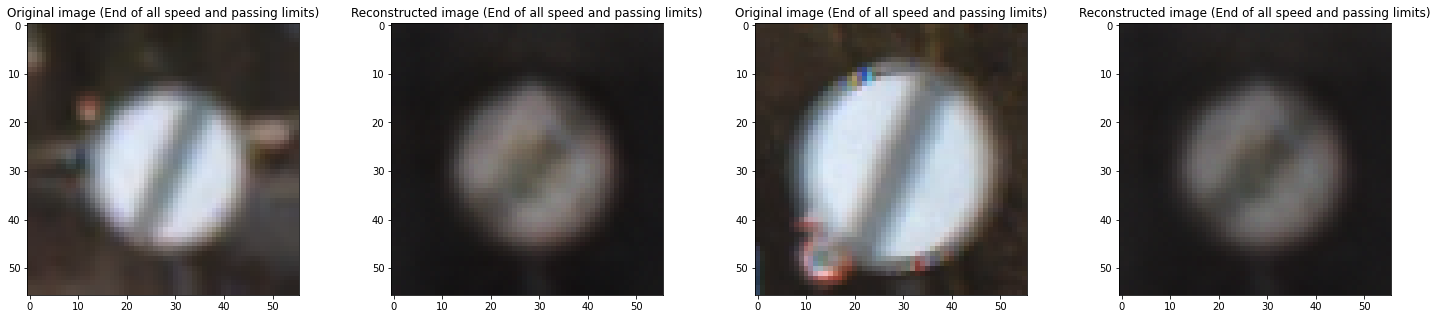

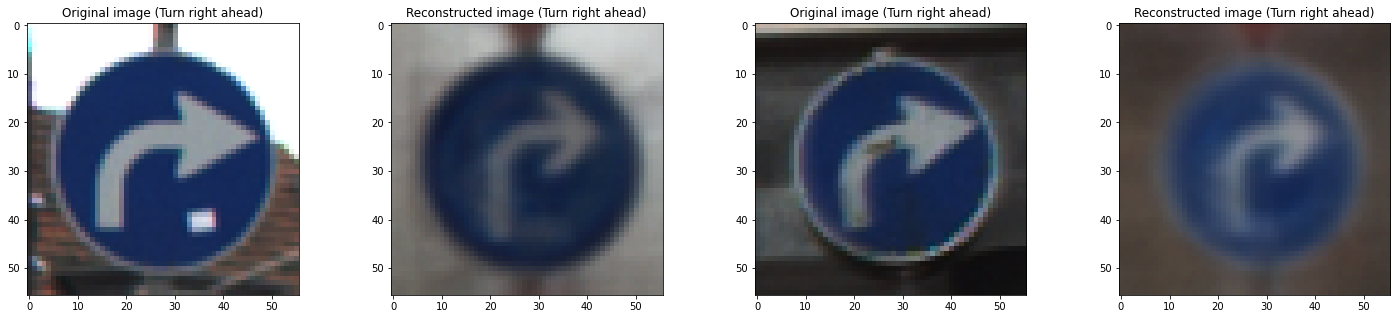

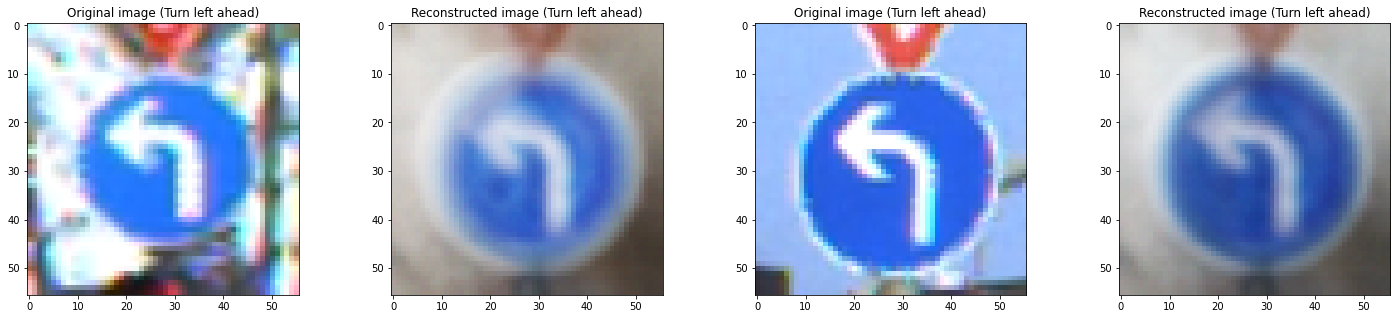

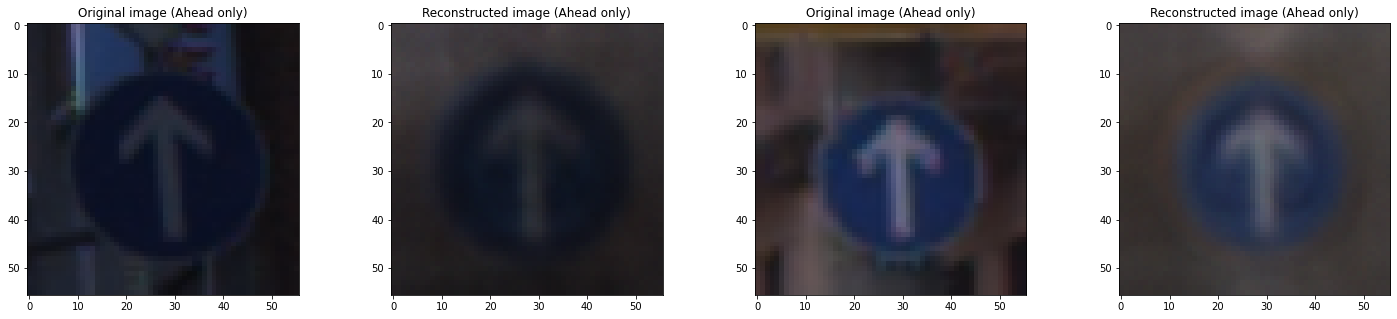

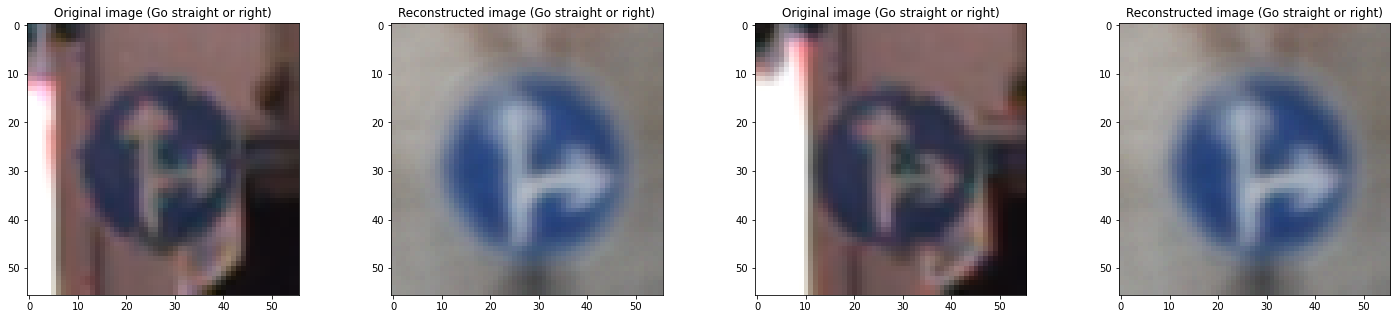

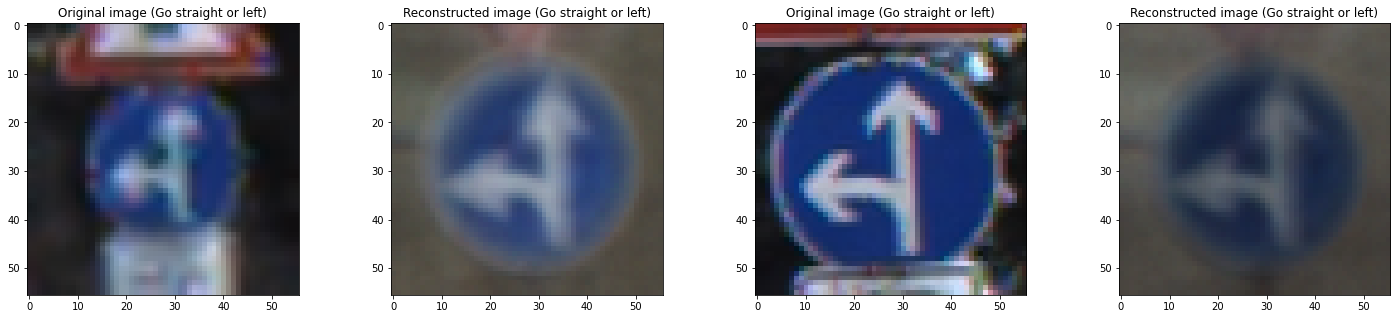

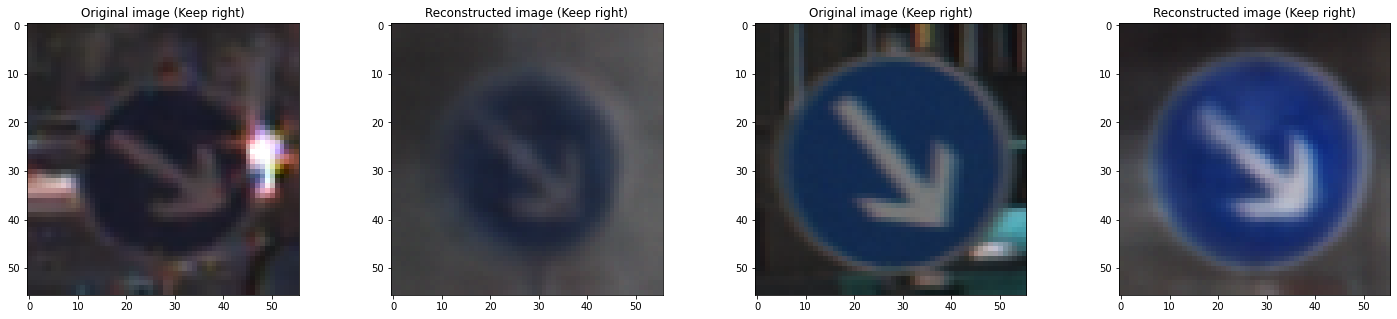

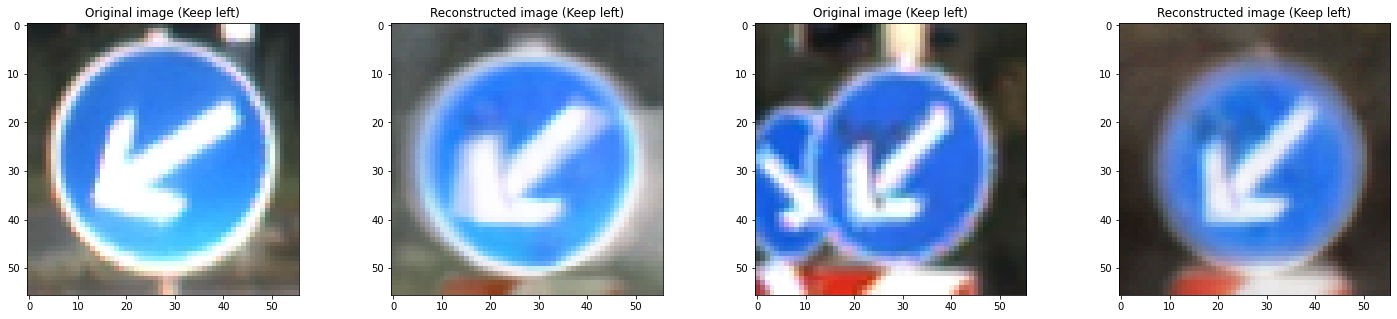

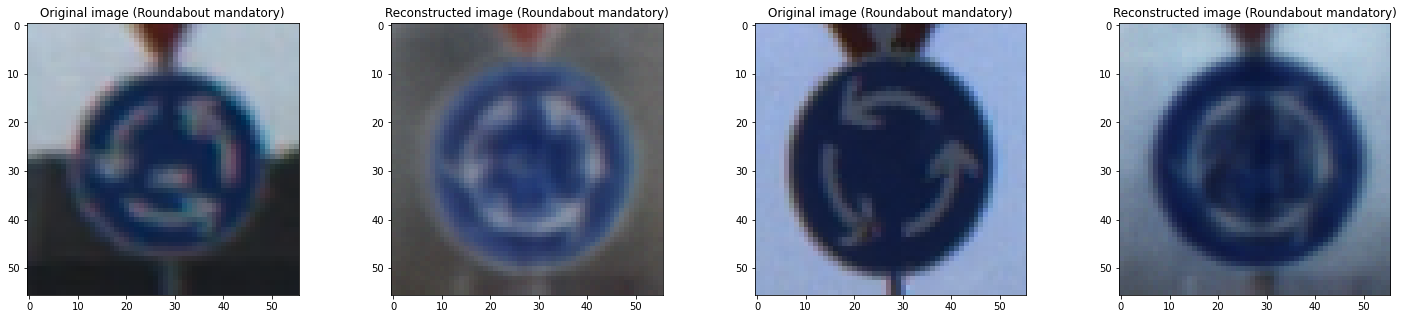

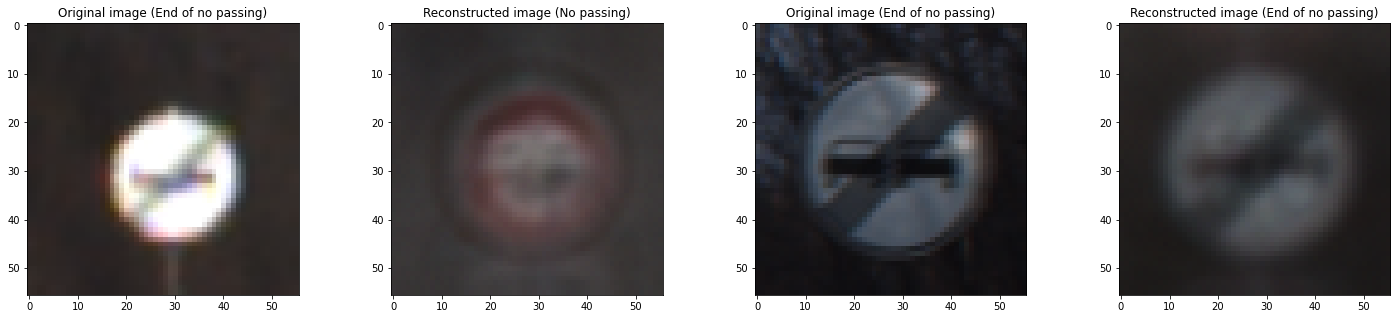

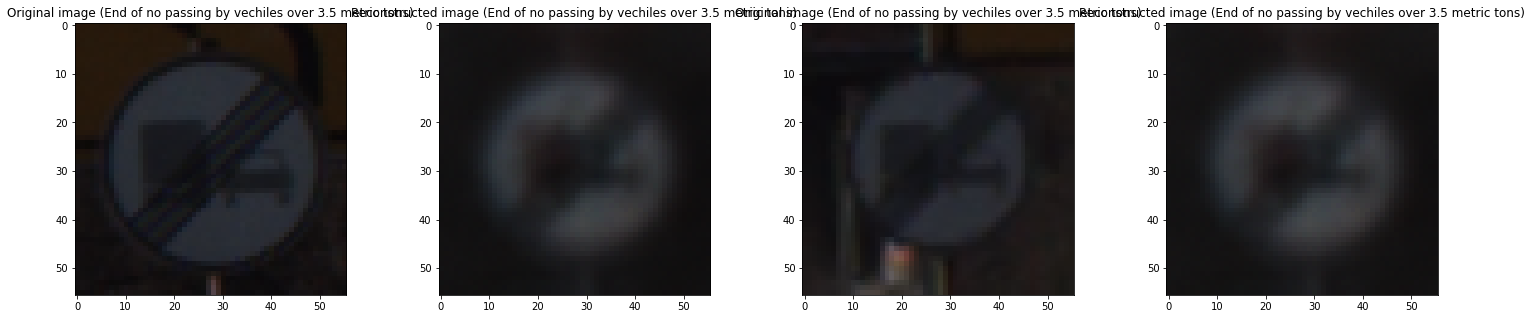

In [ ]:
for class_name in range(n_classes):
  indices = np.where(y_test_category==class_name)[0]
  rand_indices = np.random.choice(indices.shape[0], 2)
  plot_img(x_test, x_test_recon, y_test, y_test_pred, indices[rand_indices[0]], indices[rand_indices[1]])

  